In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import torch.nn as nn
import torch
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from torch.amp import autocast, GradScaler
import random

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

device = "cuda" if torch.cuda.is_available() else "cpu"

def set_global_seed(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

    try:
        import cv2
        cv2.setRNGSeed(seed)
    except:
        pass

set_global_seed(42)

In [2]:
class CustomDataset(Dataset):
    """ 
    Custom Dataset that loads all pictures into the memory at the start.
    """
    def __init__(self, root):
        self.class_names = sorted(os.listdir(root))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}
        self.paths = sorted(glob(f"{root}/*/*"))

        print("Loading in ram...")
        self.images = []
        self.labels = []

        for i, path in enumerate(self.paths):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            label_name = os.path.basename(os.path.dirname(path))
            label = self.class_to_idx[label_name]

            self.images.append(img)
            self.labels.append(label)

            if i % 500 == 0:
                print(f"{i}/{len(self.paths)} pictures loaded...")

        print(f"Loading completed. {len(self.images)} pictures loaded.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

root = os.path.join("Lung X-Ray Image", "Lung X-Ray Image")

dataset = CustomDataset(root)
num_classes = len(dataset.class_names)

Loading in ram...
0/3319 pictures loaded...
500/3319 pictures loaded...
1000/3319 pictures loaded...
1500/3319 pictures loaded...
2000/3319 pictures loaded...
2500/3319 pictures loaded...
3000/3319 pictures loaded...
Loading completed. 3319 pictures loaded.


In [3]:
class TransformDataset(Dataset):
    """" 
    This wrapper applies transformations on-the-fly to the existing dataset.
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        
        if self.transform:
            img = self.transform(img)
        return img, label

In [4]:
class CLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8), p=0.5):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            if isinstance(img, torch.Tensor):
                img_np = img.permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = np.array(img)
            
            clahe = cv2.createCLAHE(
                clipLimit=self.clip_limit,
                tileGridSize=self.tile_grid_size
            )
            
            if len(img_np.shape) == 3:
                img_clahe = np.zeros_like(img_np)
                for i in range(img_np.shape[2]):
                    img_clahe[:, :, i] = clahe.apply(img_np[:, :, i])
            else:
                img_clahe = clahe.apply(img_np)
            
            img = torch.from_numpy(img_clahe).float() / 255.0
            if len(img_clahe.shape) == 3:
                img = img.permute(2, 0, 1)
        
        return img

class GaussianNoise:
    def __init__(self, mean=0.0, std=0.02, p=0.3):
        self.mean = mean
        self.std = std
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            noise = torch.randn_like(img) * self.std + self.mean
            img = img + noise
            img = torch.clamp(img, 0.0, 1.0)
        return img

class RandomGamma:
    def __init__(self, gamma_range=(0.8, 1.2), p=0.5):
        self.gamma_range = gamma_range
        self.p = p
        
    def __call__(self, img):
        if random.random() < self.p:
            gamma = random.uniform(*self.gamma_range)
            img = torch.pow(img, gamma)
        return img

In [5]:
train_transform = T.Compose([
    CLAHE(clip_limit=2.5, tile_grid_size=(8, 8), p=0.6),
    T.ColorJitter(brightness=0.25, contrast=0.25),
    RandomGamma(gamma_range=(0.8, 1.2), p=0.5),
    GaussianNoise(mean=0.0, std=0.02, p=0.3),
    T.Normalize(mean=[0.5], std=[0.5])
])

val_transform = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5])
])

test_transform = T.Compose([
    CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    T.Normalize(mean=[0.5], std=[0.5])
])

In [6]:
total = len(dataset)
test_size = int(0.15 * total)
val_size = int(0.15 * total)
train_size = total - val_size - test_size

train_base, val_base, test_base = random_split(dataset, [train_size, val_size, test_size])

train_dataset = TransformDataset(train_base, transform=train_transform)
val_dataset   = TransformDataset(val_base,   transform=val_transform)
test_dataset  = TransformDataset(test_base,  transform=test_transform)

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes, input_size=299, dropout=0.5):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),
        )

        feature_size = input_size // 8
        flattened_size = 128 * feature_size * feature_size

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [8]:
def train_one_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        with autocast(device):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.detach()

    return (running_loss / len(loader)).item()


def validate(model, loader, criterion, device):
    model.eval()
    total_correct = 0
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast(device):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.detach()
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == labels).sum()
            total_samples += labels.size(0)

    avg_loss = (running_loss / len(loader)).item()
    accuracy = (total_correct / total_samples).item()
    
    return avg_loss, accuracy

### Hyper parameter search

In [ ]:
import itertools

def hyperparameter_search(train_loader, val_loader, num_classes, device):
    print("Search start. Device:", device)

    param_grid = {
        "lr": [1e-3, 5e-4],
        "optimizer": ["adam", "sgd"],
        "dropout": [0.3, 0.5]
    }

    best_acc = 0
    best_params = None
    best_model_state = None

    scaler = torch.amp.GradScaler('cuda')

    for lr, opt_name, dropout in itertools.product(param_grid["lr"], param_grid["optimizer"], param_grid["dropout"]):
        print(f"\nTest hyper-params : lr={lr}, optimizer={opt_name}, dropout={dropout}")

        model = CNN(num_classes, input_size=299).to(device)
        model.classifier[3] = nn.Dropout(dropout)

        criterion = nn.CrossEntropyLoss()

        if opt_name == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        for epoch in range(20): 
            train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
            val_loss, val_acc = validate(model, val_loader, criterion, device)
            print(f"Epoch {epoch+1}: val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_params = {"lr": lr, "optimizer": opt_name, "dropout": dropout}
            best_model_state = model.state_dict()

    return best_params, best_acc, best_model_state

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2*64, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=2*64, shuffle=False, num_workers=0, pin_memory=True)

best_params, best_acc, best_state = hyperparameter_search(
    train_loader,
    val_loader,
    num_classes,
    device
)
print("Best parameters found :", best_params)
print(f"Best val accuracy: {best_acc:.4f}")

Search start. Device: cuda

🔍 Test hyper-params : lr=0.001, optimizer=adam, dropout=0.3
Epoch 1: val_loss=0.6223, val_acc=0.7308
Epoch 2: val_loss=0.4812, val_acc=0.7923
Epoch 3: val_loss=0.4374, val_acc=0.8423
Epoch 4: val_loss=0.3958, val_acc=0.8404
Epoch 5: val_loss=0.4084, val_acc=0.8500
Epoch 6: val_loss=0.3553, val_acc=0.8673
Epoch 7: val_loss=0.3909, val_acc=0.8596
Epoch 8: val_loss=0.3612, val_acc=0.8500
Epoch 9: val_loss=0.3899, val_acc=0.8615
Epoch 10: val_loss=0.3566, val_acc=0.8731
Epoch 11: val_loss=0.3362, val_acc=0.8731
Epoch 12: val_loss=0.3832, val_acc=0.8635
Epoch 13: val_loss=0.4377, val_acc=0.8596
Epoch 14: val_loss=0.3694, val_acc=0.8635
Epoch 15: val_loss=0.3564, val_acc=0.8846
Epoch 16: val_loss=0.4031, val_acc=0.8827
Epoch 17: val_loss=0.3844, val_acc=0.8596
Epoch 18: val_loss=0.4178, val_acc=0.8808
Epoch 19: val_loss=0.4062, val_acc=0.8885
Epoch 20: val_loss=0.4625, val_acc=0.8769

🔍 Test hyper-params : lr=0.001, optimizer=adam, dropout=0.5
Epoch 1: val_loss=0.

Best parameters :
- lr = 0.0005
- optimizer = Adam
- dropout = 0.5

# Training model on best parameters

In [18]:
if device == 'cuda':
    torch.cuda.empty_cache()

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

cnn = CNN(num_classes, input_size=299, dropout=0.5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn.parameters(), lr=0.0005, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scaler = torch.amp.GradScaler('cuda')

train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = 100.0
best_epoch = 0

num_epochs = 30

for epoch in range(num_epochs):
    train_loss = train_one_epoch(cnn, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc = validate(cnn, val_loader, criterion, device)

    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save(cnn.state_dict(), "saved_models/cnn.pth")
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f} | New best saved.")
    else:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

if device== 'cuda':
    torch.cuda.empty_cache()

Epoch 1/30: train_loss=10.2529, val_loss=0.6070, val_acc=0.7646 | New best saved.
Epoch 2/30: train_loss=0.6813, val_loss=0.4944, val_acc=0.7988 | New best saved.
Epoch 3/30: train_loss=0.5885, val_loss=0.4391, val_acc=0.8249 | New best saved.
Epoch 4/30: train_loss=0.5205, val_loss=0.4587, val_acc=0.8109
Epoch 5/30: train_loss=0.5218, val_loss=0.4400, val_acc=0.8068
Epoch 6/30: train_loss=0.4950, val_loss=0.4289, val_acc=0.8028 | New best saved.
Epoch 7/30: train_loss=0.5011, val_loss=0.4107, val_acc=0.8129 | New best saved.
Epoch 8/30: train_loss=0.4671, val_loss=0.3940, val_acc=0.8229 | New best saved.
Epoch 9/30: train_loss=0.4175, val_loss=0.4270, val_acc=0.8189
Epoch 10/30: train_loss=0.4267, val_loss=0.3900, val_acc=0.8390 | New best saved.
Epoch 11/30: train_loss=0.4493, val_loss=0.3748, val_acc=0.8390 | New best saved.
Epoch 12/30: train_loss=0.4272, val_loss=0.3799, val_acc=0.8390
Epoch 13/30: train_loss=0.4098, val_loss=0.3678, val_acc=0.8471 | New best saved.
Epoch 14/30: t

### Learning curves

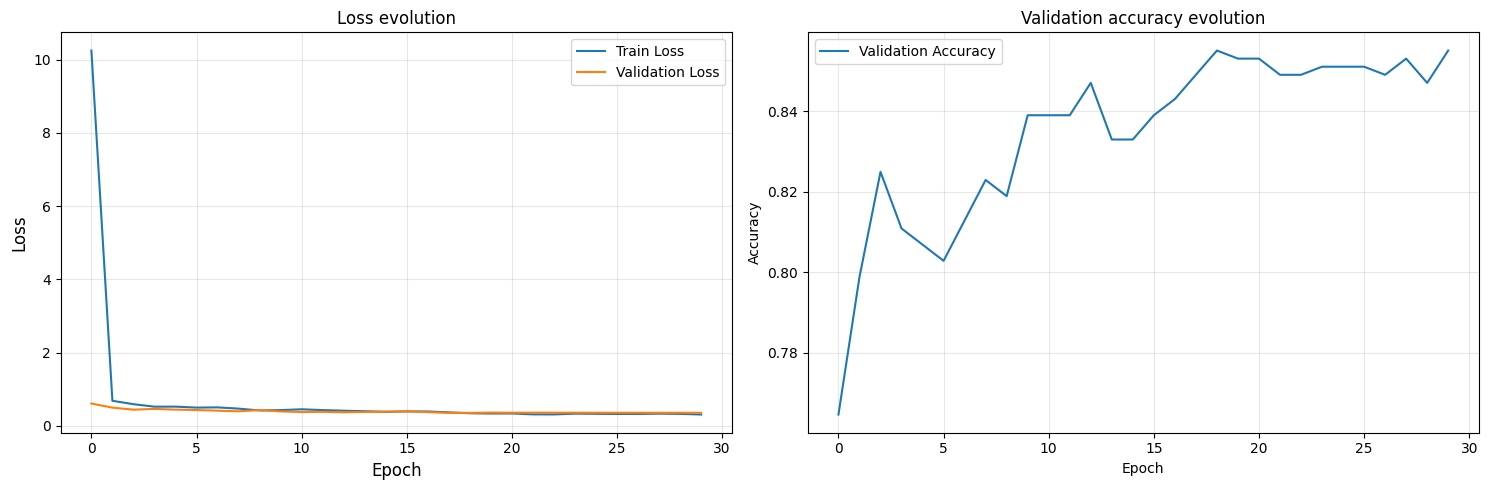

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss evolution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation accuracy evolution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluation

In [20]:
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

cnn = CNN(num_classes, input_size=299, dropout=0.5).to(device)
cnn.load_state_dict(torch.load("saved_models/cnn.pth"))
cnn.eval()

CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.3, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten

Test accuracy: 0.8632

Classification Report:
                 precision    recall  f1-score   support

   Lung_Opacity     0.8176    0.8075    0.8125       161
         Normal     0.8158    0.8470    0.8311       183
Viral Pneumonia     0.9730    0.9412    0.9568       153

       accuracy                         0.8632       497
      macro avg     0.8688    0.8652    0.8668       497
   weighted avg     0.8648    0.8632    0.8638       497



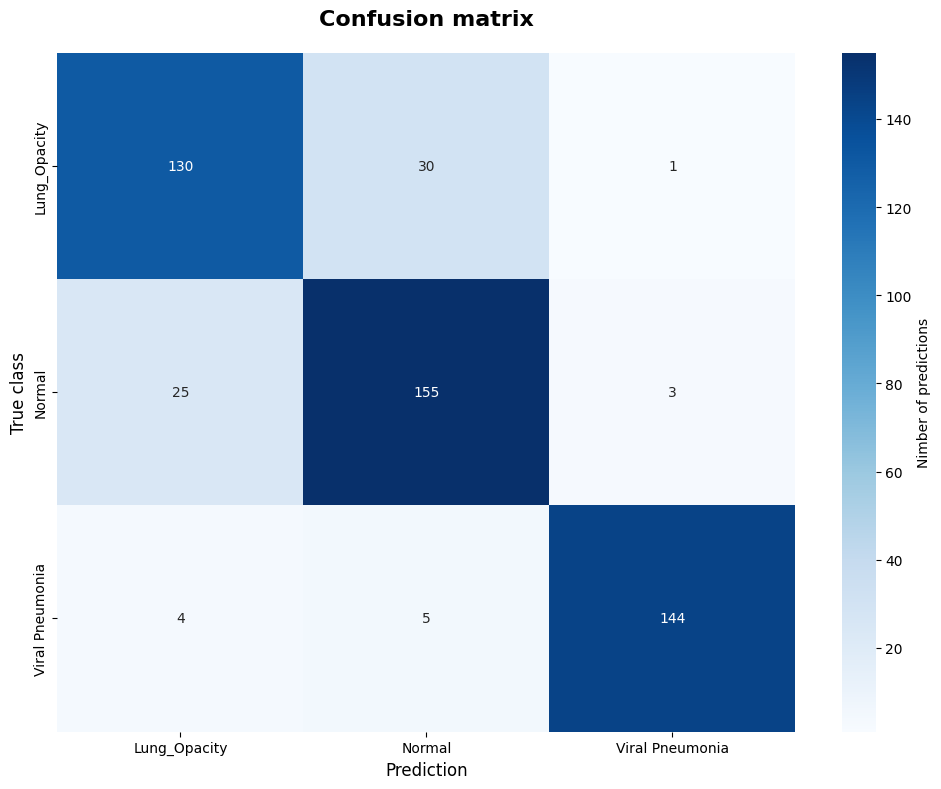

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        with autocast(device):
            outputs = cnn(images)
        
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.class_names, digits=4))


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dataset.class_names, 
            yticklabels=dataset.class_names,
            cbar_kws={'label': 'Nimber of predictions'})
plt.title('Confusion matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.tight_layout()
plt.show()

### Visualizing convolution kernel

In [13]:
first_conv_layer = cnn.features[0]
kernels = first_conv_layer.weight.data.cpu()

print(f"Shape: {kernels.shape}")
print(f"Filters amount: {kernels.shape[0]}")
print(f"Size: {kernels.shape[2]}x{kernels.shape[3]}")

Shape: torch.Size([32, 3, 3, 3])
Filters amount: 32
Size: 3x3


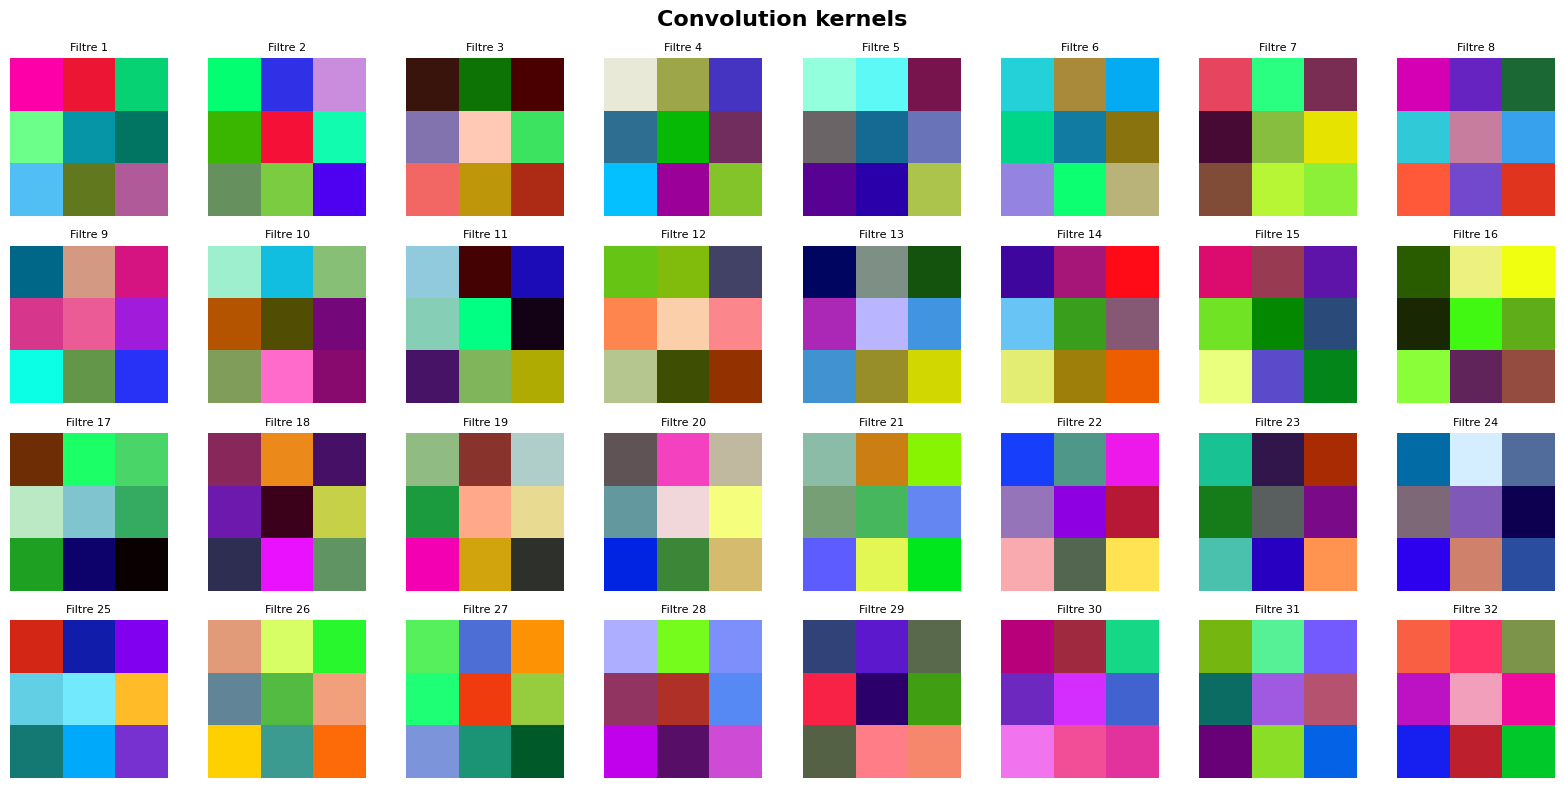

In [14]:
n_filters = kernels.shape[0]
n_cols = 8
n_rows = (n_filters + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*2))
axes = axes.flatten()

for i in range(n_filters):
    kernel = kernels[i].numpy()

    kernel_norm = (kernel - kernel.min()) / (kernel.max() - kernel.min() + 1e-8)

    kernel_display = np.transpose(kernel_norm, (1, 2, 0))
    
    axes[i].imshow(kernel_display)
    axes[i].set_title(f'Filtre {i+1}', fontsize=8)
    axes[i].axis('off')


for i in range(n_filters, len(axes)):
    axes[i].axis('off')

plt.suptitle('Convolution kernels', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

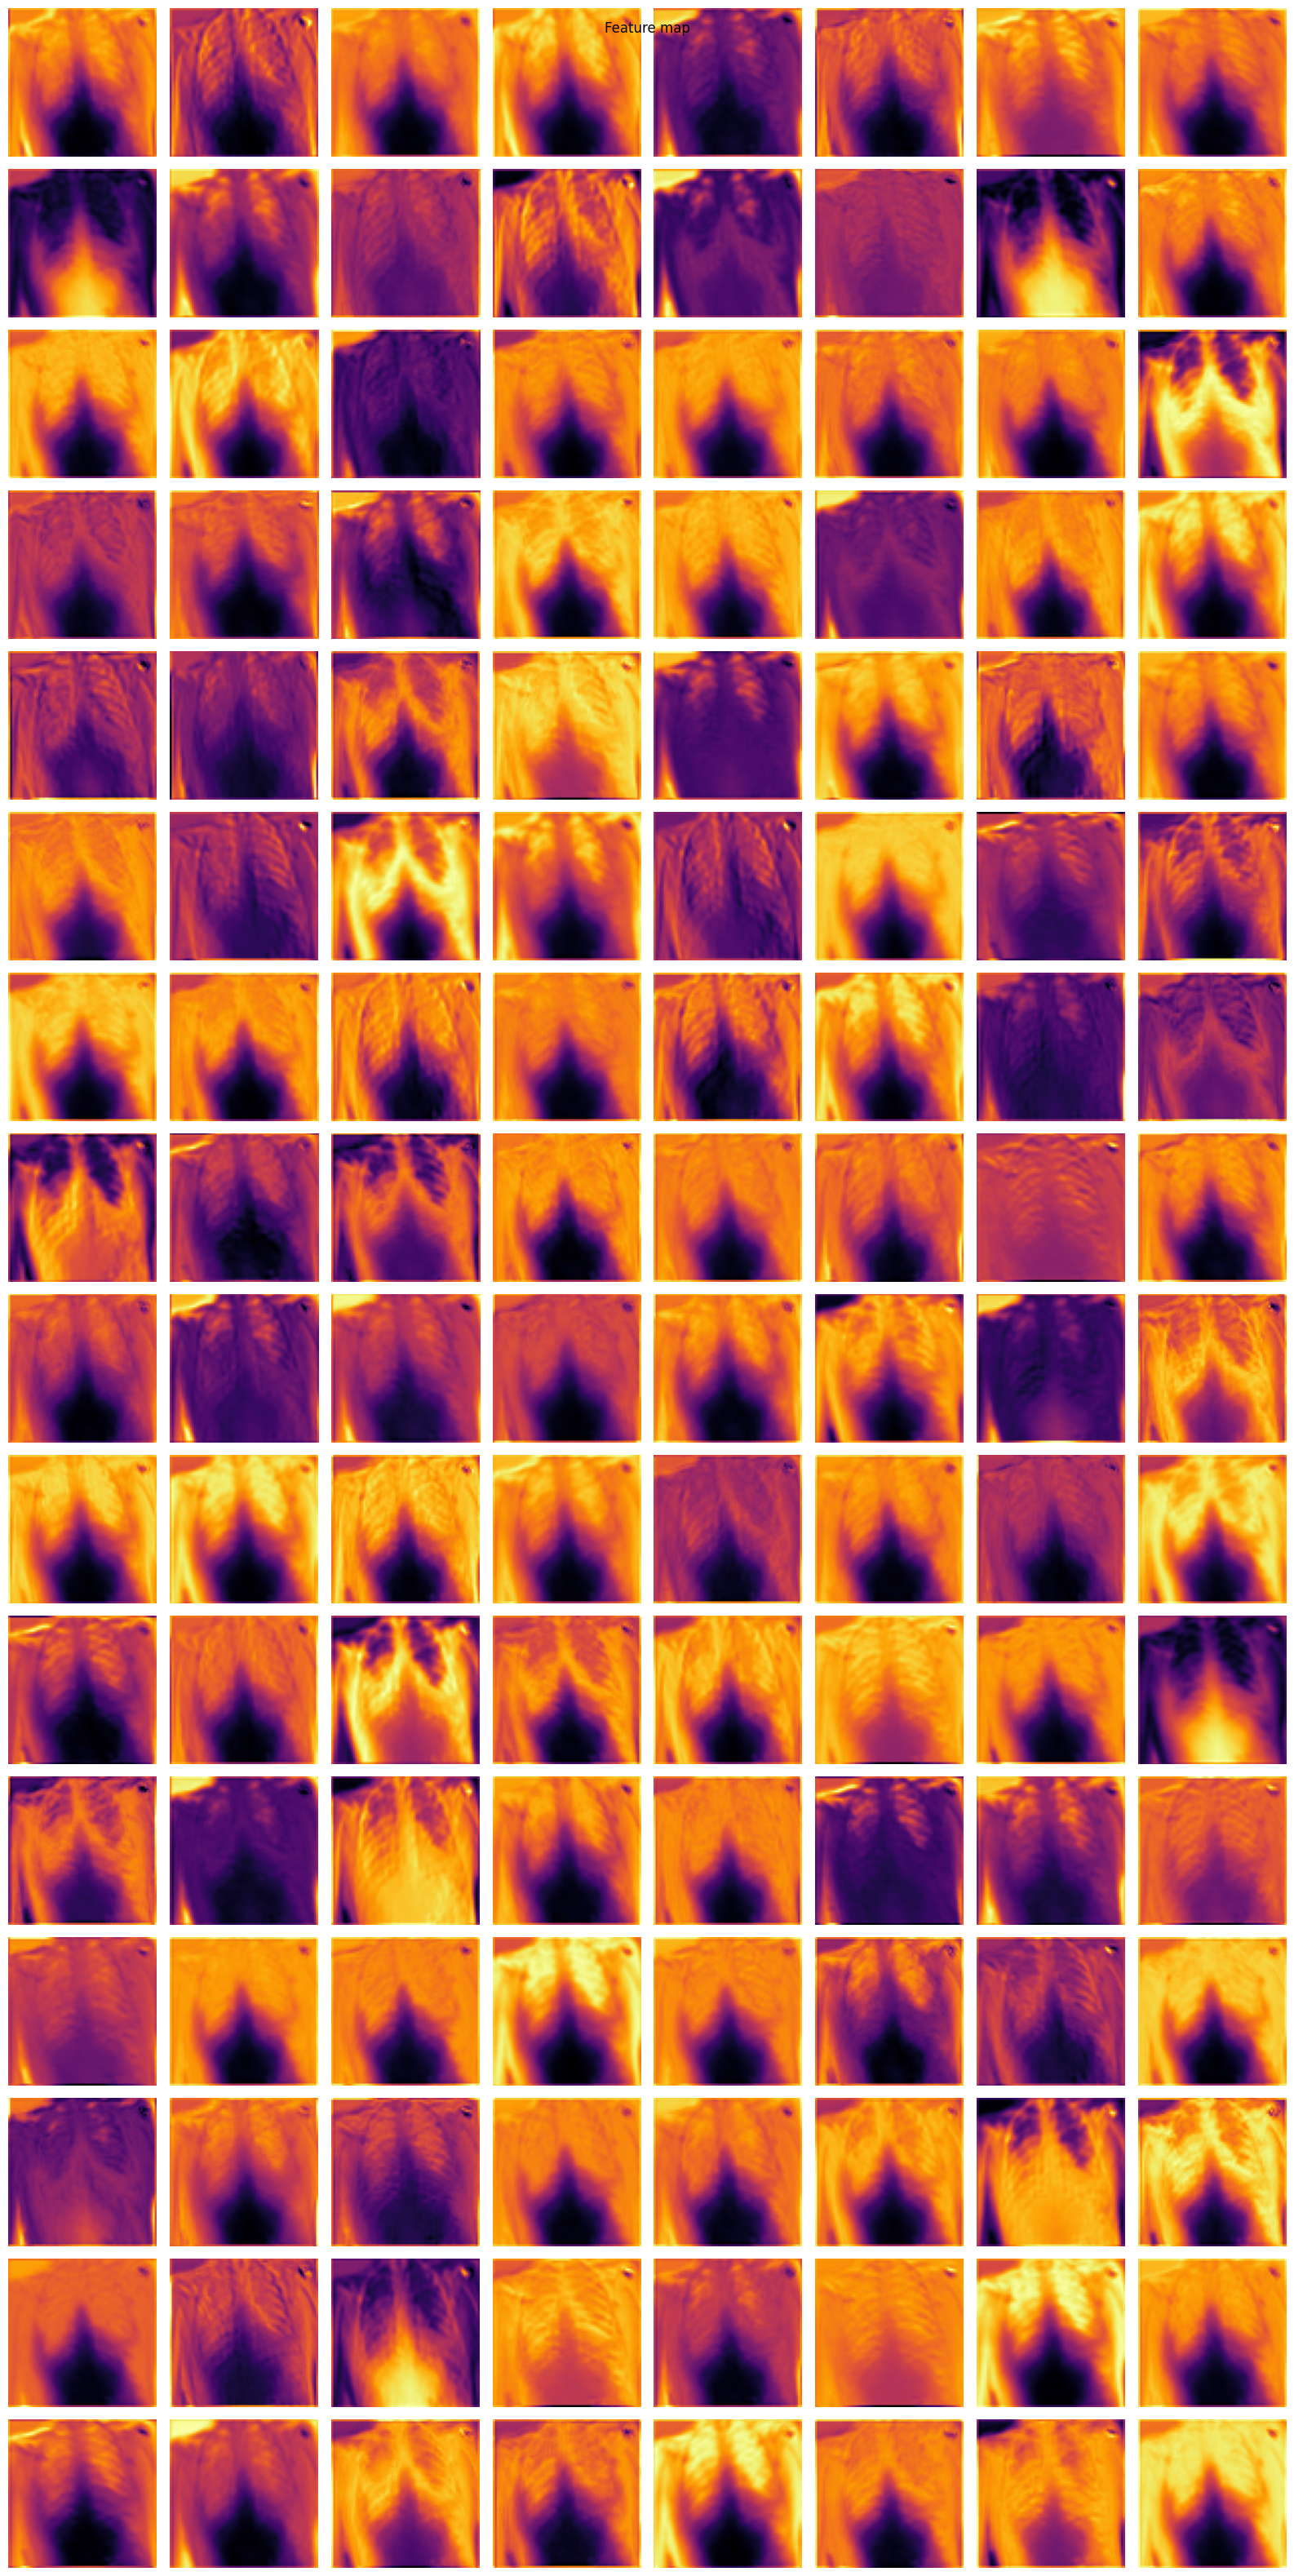

In [15]:
import math

first_image, first_label = dataset[0] 
first_image_tensor = torch.from_numpy(first_image).permute(2, 0, 1).float() / 255.0 
first_image_tensor = first_image_tensor.unsqueeze(0).to(device)

layers_outputs = []
x = first_image_tensor

for layer in cnn.features:
    x = layer(x)
    if isinstance(layer, nn.Conv2d):
        layers_outputs.append(x.clone().detach().cpu())

last_feature_tensor = layers_outputs[-1].squeeze(0)
n_maps = last_feature_tensor.shape[0]

cols = 8
rows = math.ceil(n_maps / cols)

plt.figure(figsize=(cols*2, rows*2))
plt.suptitle("Feature map")

for i in range(n_maps):
    plt.subplot(rows, cols, i+1)
    plt.imshow(last_feature_tensor[i].numpy(), cmap='inferno')
    plt.axis('off')

plt.tight_layout()
plt.show()


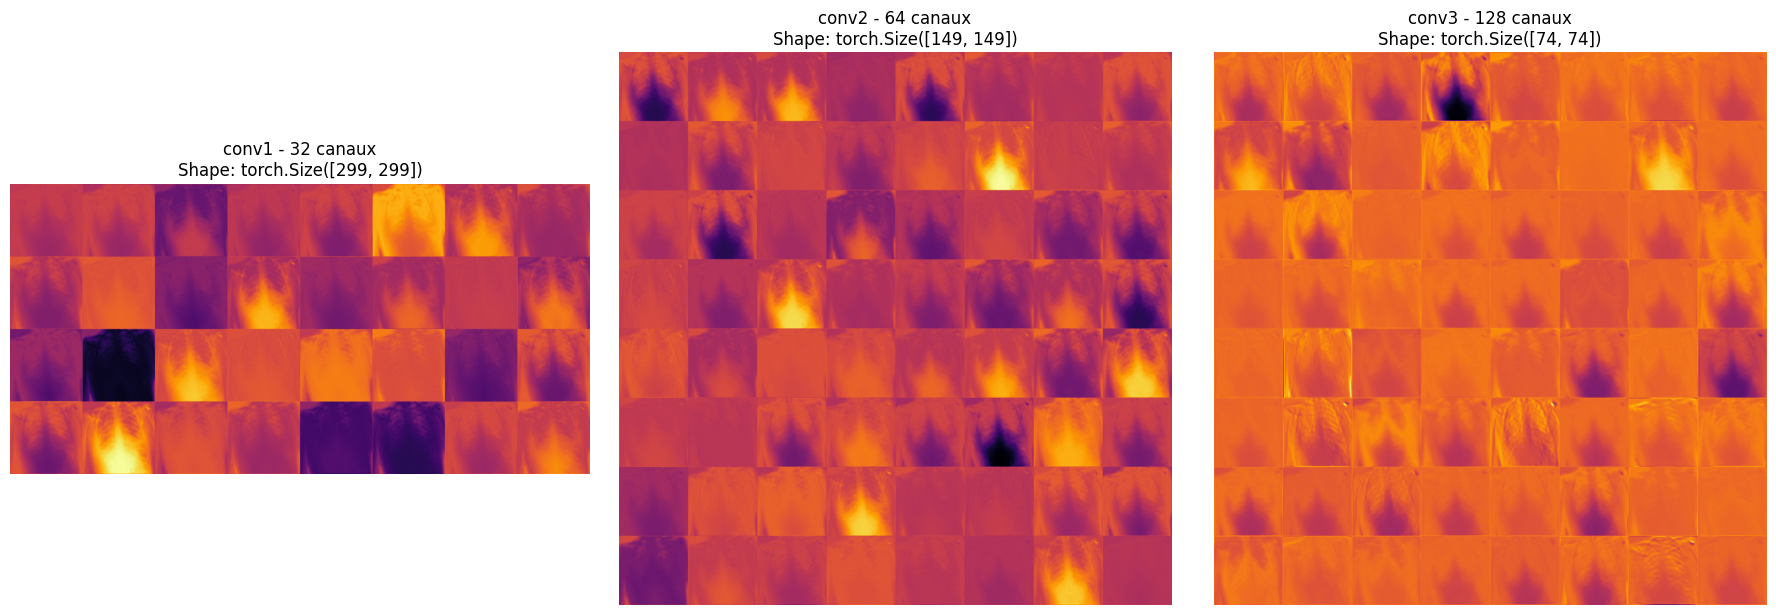

In [16]:
import math
import torch

first_image, first_label = dataset[0] 
first_image_tensor = torch.from_numpy(first_image).permute(2, 0, 1).float() / 255.0 
first_image_tensor = first_image_tensor.unsqueeze(0).to(device)

layers_outputs = {}

def get_activation(name):
    def hook(model, input, output):
        layers_outputs[name] = output.detach()
    return hook

# Enregistrer les hooks sur les couches convolutionnelles
# features[0] = Conv2d(3, 32)
# features[3] = Conv2d(32, 64)
# features[6] = Conv2d(64, 128)
cnn.features[0].register_forward_hook(get_activation('conv1'))
cnn.features[3].register_forward_hook(get_activation('conv2'))
cnn.features[6].register_forward_hook(get_activation('conv3'))

cnn.eval()
with torch.no_grad():
    _ = cnn(first_image_tensor)

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
layer_names = ['conv1', 'conv2', 'conv3']

for idx, layer_name in enumerate(layer_names):
    ax = axes[idx]
    
    feature_tensor = layers_outputs[layer_name].squeeze(0).cpu()
    n_maps = min(64, feature_tensor.shape[0])
    
    # Créer une grille de feature maps
    cols = 8
    rows = math.ceil(n_maps / cols)
    
    # Créer une grille de visualisation
    grid = []
    for i in range(rows):
        row_maps = []
        for j in range(cols):
            map_idx = i * cols + j
            if map_idx < n_maps:
                row_maps.append(feature_tensor[map_idx].numpy())
            else:
                # Remplir avec des zeros si pas assez de feature maps
                row_maps.append(torch.zeros_like(feature_tensor[0]).numpy())
        grid.append(np.hstack(row_maps))
    
    grid_img = np.vstack(grid)
    
    ax.imshow(grid_img, cmap='inferno')
    ax.set_title(f'{layer_name} - {feature_tensor.shape[0]} canaux\nShape: {feature_tensor.shape[1:]}')
    ax.axis('off')

plt.tight_layout()
plt.show()